<a href="https://colab.research.google.com/github/tomonari-masada/course2022-sml/blob/main/06_linear_regression_1_(in_class).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#6. 実データの単回帰分析

##6.1 description vs prediction 

今回は、単回帰をpredictionにではなくdescriptionに使う。

* description＝与えられたデータを理解する (EDA: exploratory data analysis)

* prediction＝未知の入力について出力を求めたい（機械学習の主戦場）

* explanation＝因果関係の理解まで含む

 * cf. https://arxiv.org/abs/1101.0891


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### この資料を作るために参考にした本

* Laura Igual and Santi Seguí. *Introduction to Data Science: A Python Approach to Concepts, Techniques and Applications.* Springer, 2017.

 * https://link.springer.com/book/10.1007%2F978-3-319-50017-1

# 使用するデータ
* 北半球と南半球の海氷域面積を分析し、面積が減少傾向にあるのかどうかを調べてみる。（上の本の6.2.1節より。）
 * 単回帰なので線形トレンドを調べるだけ。
 * Rでは`notrend_test`という関数を使えばよいらしい。

* データは、下記の場所から取得。

 * https://nsidc.org/data/seaice_index/archives


 * 以下の2つのファイルをダウンロードしておく。
  *   [北極域の海氷域面積データ](https://masie_web.apps.nsidc.org/pub//DATASETS/NOAA/G02135/north/daily/data/N_seaice_extent_daily_v3.0.csv)
  *   [南極域の海氷域面積データ](https://masie_web.apps.nsidc.org/pub//DATASETS/NOAA/G02135/south/daily/data/S_seaice_extent_daily_v3.0.csv)



# 線形トレンドの分析

## 1) データファイルを読み込んで前処理をする

In [29]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm

%config InlineBackend.figure_format = 'retina'

* 北半球のデータを扱う（南半球のデータは自習）

In [30]:
n_ice = pd.read_csv('/content/drive/MyDrive/2022Courses/sml/N_seaice_extent_daily_v3.0.csv')
n_ice.shape

(14217, 6)

In [31]:
n_ice.head()

,Year,Month,Day,Extent,Missing,Source Data
0,YYYY,MM,DD,10^6 sq km,10^6 sq km,Source data product web sites: http://nsidc.o...
1,1978,10,26,10.231,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.26/nt_19...
2,1978,10,28,10.420,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.28/nt_19...
3,1978,10,30,10.557,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.30/nt_19...
4,1978,11,01,10.670,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1978.11.01/nt_19...


* 必ずしも毎日のデータがあるわけではないことが分かる。（例：1978年10月27日のデータはない。）

* 最初の行はデータのフォーマットの説明なので、消す。

In [32]:
n_ice = n_ice.drop(0, axis=0)

In [33]:
n_ice.head()

,Year,Month,Day,Extent,Missing,Source Data
1,1978,10,26,10.231,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.26/nt_19...
2,1978,10,28,10.420,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.28/nt_19...
3,1978,10,30,10.557,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.30/nt_19...
4,1978,11,01,10.670,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1978.11.01/nt_19...
5,1978,11,03,10.777,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1978.11.03/nt_19...


In [34]:
n_ice.tail()

,Year,Month,Day,Extent,Missing,Source Data
14212,2022,04,02,14.383,0.000,['/ecs/DP1/PM/NSIDC-0081.001/2022.04.01/nt_202...
14213,2022,04,03,14.353,0.000,['/ecs/DP1/PM/NSIDC-0081.001/2022.04.02/nt_202...
14214,2022,04,04,14.438,0.000,['/ecs/DP1/PM/NSIDC-0081.001/2022.04.03/nt_202...
14215,2022,04,05,14.387,0.000,['/ecs/DP1/PM/NSIDC-0081.001/2022.04.04/nt_202...
14216,2022,04,06,14.333,0.000,['/ecs/DP1/PM/NSIDC-0081.001/2022.04.05/nt_202...


In [35]:
n_ice.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14216 entries, 1 to 14216
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Year          14216 non-null  object
 1    Month        14216 non-null  object
 2    Day          14216 non-null  object
 3        Extent   14216 non-null  object
 4       Missing   14216 non-null  object
 5    Source Data  14216 non-null  object
dtypes: object(6)
memory usage: 777.4+ KB


* 1978年と2022年は一年分のデータがないので、消す。

In [36]:
n_ice = n_ice[(n_ice.Year != '1978') & (n_ice.Year != '2022')]

In [37]:
n_ice.head()

,Year,Month,Day,Extent,Missing,Source Data
35,1979,01,02,14.997,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.02/nt_19...
36,1979,01,04,14.922,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.04/nt_19...
37,1979,01,06,14.929,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.06/nt_19...
38,1979,01,08,14.968,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.08/nt_19...
39,1979,01,10,15.190,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.10/nt_19...


In [38]:
n_ice.tail()

,Year,Month,Day,Extent,Missing,Source Data
14116,2021,12,27,12.947,0.000,['/ecs/DP1/PM/NSIDC-0081.001/2021.12.26/nt_202...
14117,2021,12,28,12.978,0.000,['/ecs/DP1/PM/NSIDC-0081.001/2021.12.27/nt_202...
14118,2021,12,29,13.050,0.000,['/ecs/DP1/PM/NSIDC-0081.001/2021.12.28/nt_202...
14119,2021,12,30,13.149,0.000,['/ecs/DP1/PM/NSIDC-0081.001/2021.12.29/nt_202...
14120,2021,12,31,13.183,0.000,['/ecs/DP1/PM/NSIDC-0081.001/2021.12.30/nt_202...


* indexを打ち直す

In [39]:
n_ice.reset_index(drop=True, inplace=True)
n_ice.head()

,Year,Month,Day,Extent,Missing,Source Data
0,1979,01,02,14.997,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.02/nt_19...
1,1979,01,04,14.922,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.04/nt_19...
2,1979,01,06,14.929,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.06/nt_19...
3,1979,01,08,14.968,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.08/nt_19...
4,1979,01,10,15.190,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.10/nt_19...


In [40]:
n_ice.describe()

,Year,Month,Day,Extent,Missing,Source Data
count,14086,14086,14086,14086,14086,14086
unique,43,12,31,7962,2,14086
top,2000,10,27,14.404,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.02/nt_19...
freq,366,1209,464,10,14085,1


In [41]:
n_ice.columns

Index(['Year', ' Month', ' Day', '     Extent', '    Missing', ' Source Data'], dtype='object')

* 列名の文字列に空白があるので除去する。

In [42]:
s = '   aaa  bbb   '
print(s)
print(s.strip())

   aaa  bbb   
aaa  bbb


In [43]:
n_ice.columns = n_ice.columns.str.strip()
n_ice.columns

Index(['Year', 'Month', 'Day', 'Extent', 'Missing', 'Source Data'], dtype='object')

* 今回の分析で使わない列を消す。

In [44]:
n_ice = n_ice.drop(['Missing', 'Source Data'], axis=1)

In [45]:
n_ice.head()

,Year,Month,Day,Extent
0,1979,01,02,14.997
1,1979,01,04,14.922
2,1979,01,06,14.929
3,1979,01,08,14.968
4,1979,01,10,15.190


In [46]:
n_ice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14086 entries, 0 to 14085
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Year    14086 non-null  object
 1   Month   14086 non-null  object
 2   Day     14086 non-null  object
 3   Extent  14086 non-null  object
dtypes: object(4)
memory usage: 440.3+ KB


* 海氷域面積を浮動小数点数に変換する

In [47]:
n_ice['Extent'] = n_ice['Extent'].astype(float)
n_ice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14086 entries, 0 to 14085
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    14086 non-null  object 
 1   Month   14086 non-null  object 
 2   Day     14086 non-null  object 
 3   Extent  14086 non-null  float64
dtypes: float64(1), object(3)
memory usage: 440.3+ KB


* 単純にプロットしてみる。
 

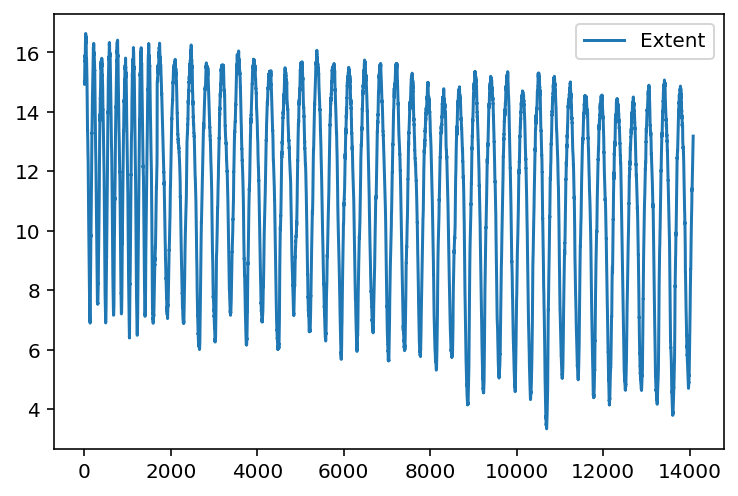

In [48]:
n_ice.plot();

* 最初の方は2日おきにしかデータが無く、そのため、グラフの様子が少し違う。
* 横軸を時間軸にしてグラフを描きなおす。

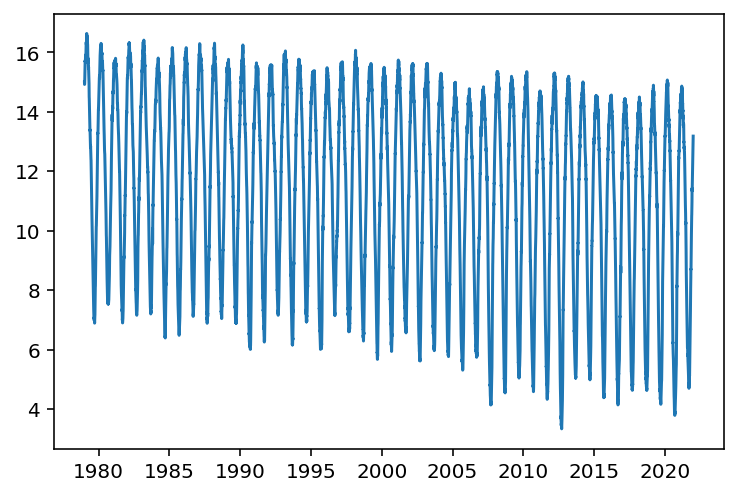

In [49]:
plt.plot(pd.to_datetime(n_ice[['Year', 'Month', 'Day']]), n_ice.Extent);

* 下降トレンドはありそう。
* 周期性があり、非常に目立つ。
* 以下、この周期性を消去しようと試みてみる。（この消し方が唯一の正解というわけではない。）

## 2) 一ヶ月ごとにデータをまとめて、平均をとる
* 今回は、データを日単位では見ないことにする。
 * 日単位で細かくデータを見て線形のトレンドを分析したい場合は、各自、試みてください。

In [51]:
n_ice_grouped = n_ice.groupby(['Year', 'Month'], as_index=False)

In [52]:
n_ice_monthly = n_ice_grouped.mean()[['Year', 'Month', 'Extent']]
n_ice_monthly.head()

,Year,Month,Extent
0,1979,01,15.414000
1,1979,02,16.175286
2,1979,03,16.341938
3,1979,04,15.446800
4,1979,05,13.856867


* もとのデータフレームを別の変数にとっておき、これ以降は月でまとめたデータを使うことにする。

In [53]:
n_ice_original = n_ice.copy()
n_ice = n_ice_monthly

* 横軸は年にし、同じ年のデータは縦方向にまとめてプロットしてみる。

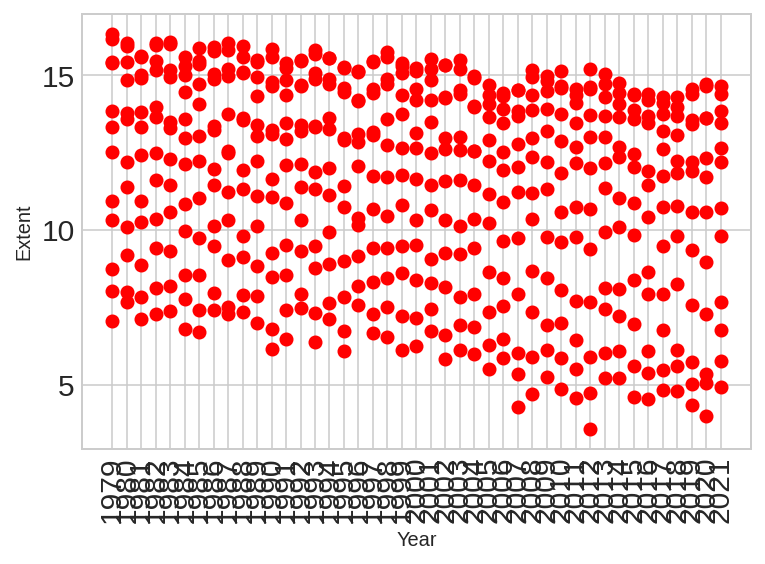

In [54]:
plt.style.use('seaborn-whitegrid')
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15) 
plt.rc('font', size=20) 
plt.rc('figure', figsize=(16,7))

x = n_ice.Year
y = n_ice.Extent
plt.scatter(x, y, color='red')
plt.xlabel('Year')
plt.ylabel('Extent');

* どうやら、一年の内で、かなり値が変動するらしい。

* 一年の内での変化が目立ち過ぎて、全体的な変化が分かりにくい。

## 3) 一年間の範囲内での変化のパターンを可視化する

* 散布図で、年の違いを横断して、各月ごとに面積データを可視化する。
* 面積データに季節性があるかどうかを確認する。

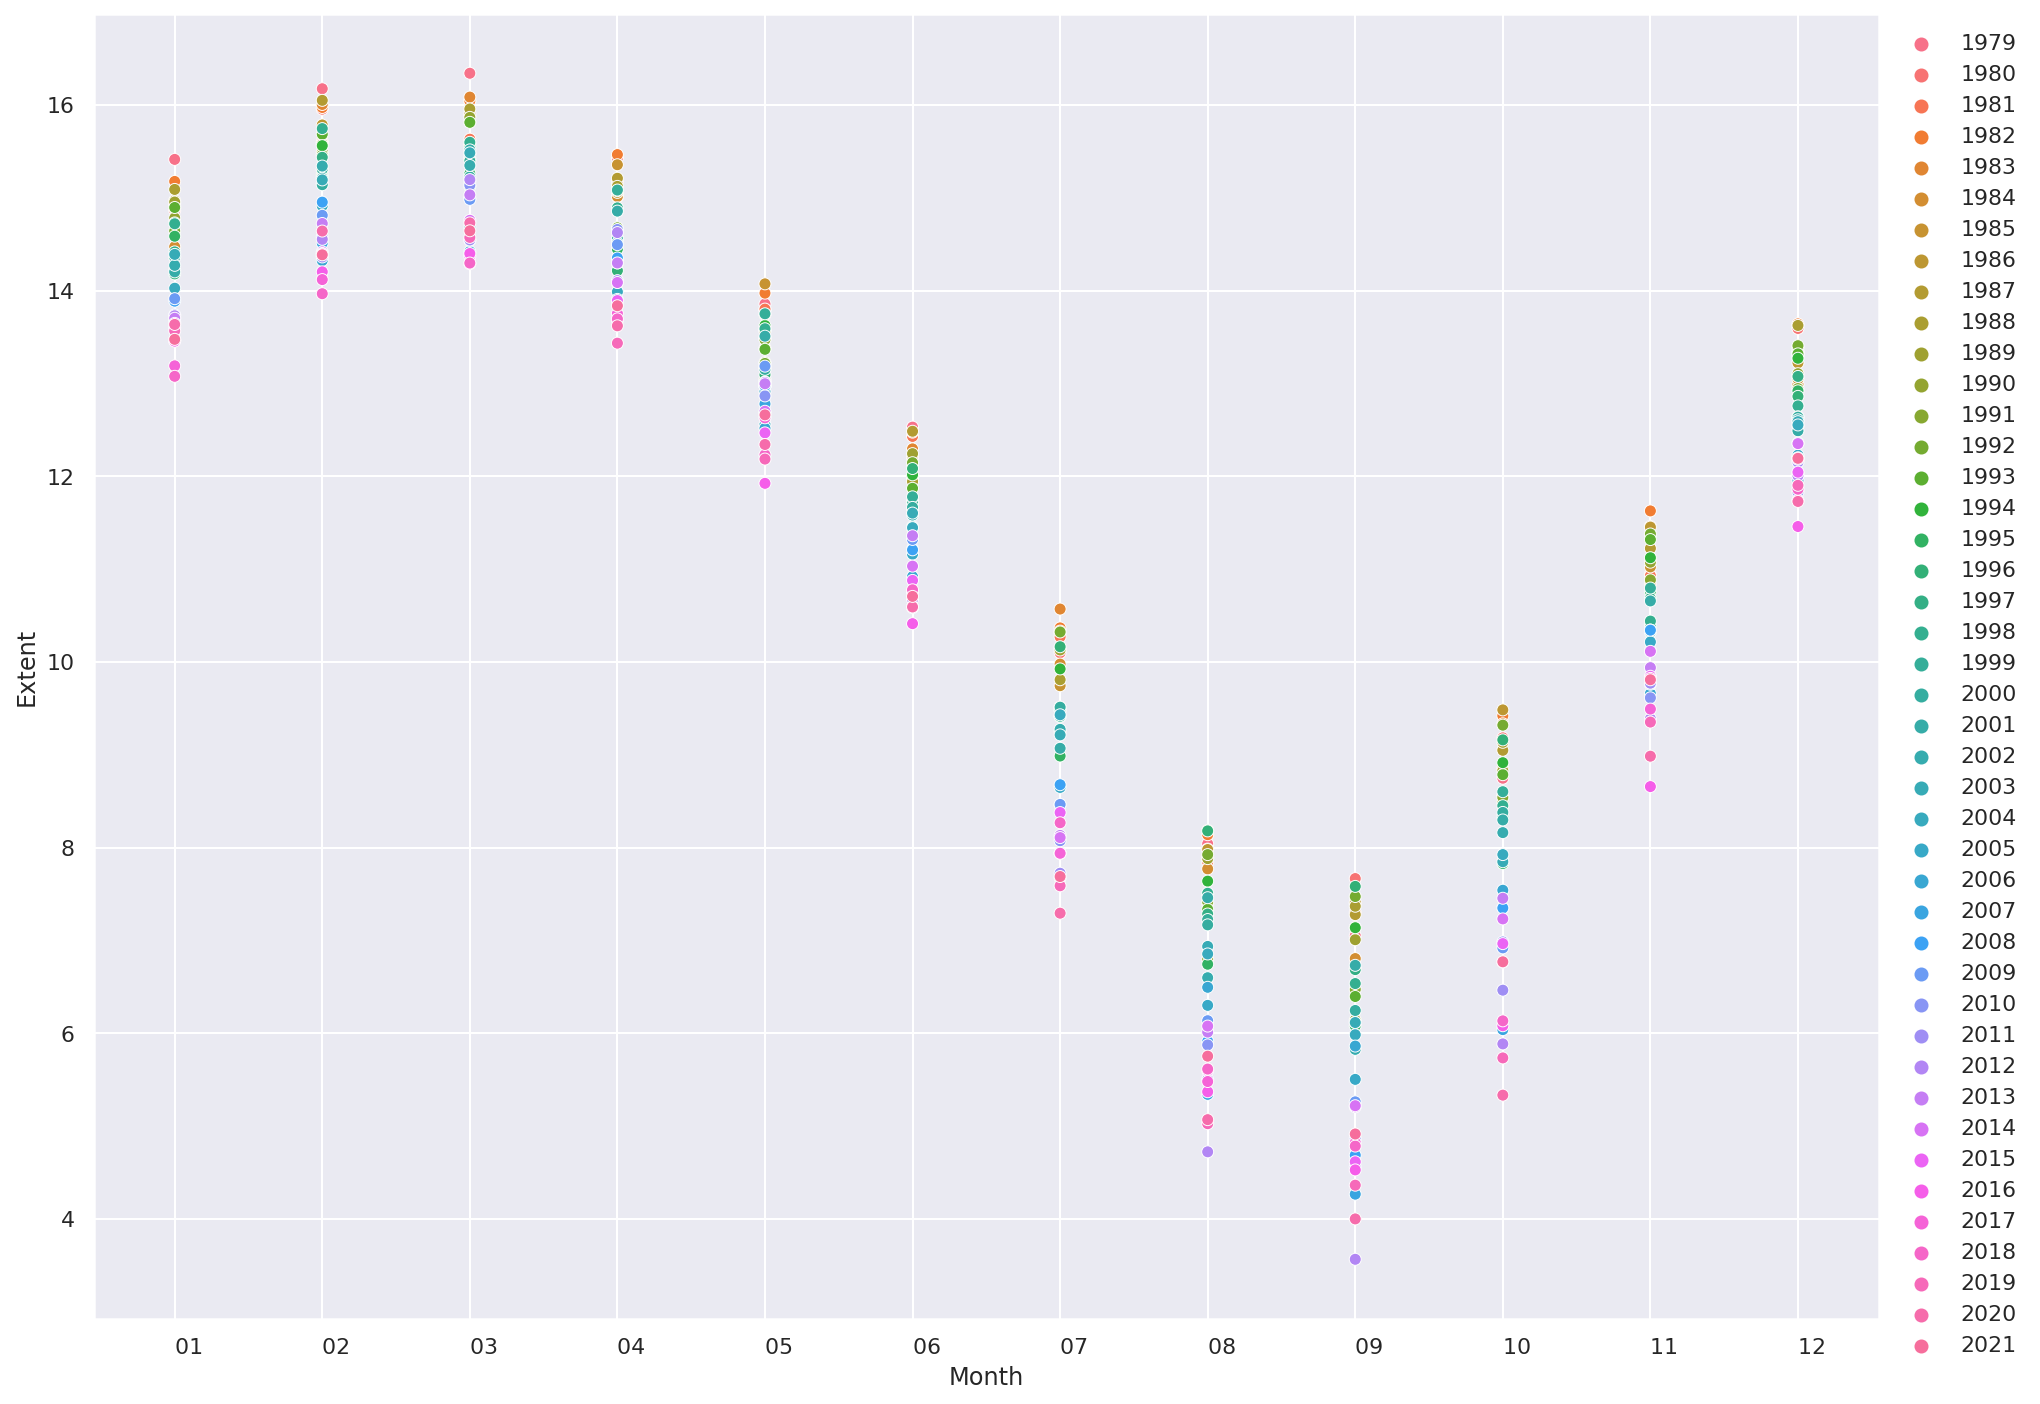

In [55]:
sns.set(rc={'figure.figsize':(16,12)})
sns.scatterplot(x="Month", y="Extent", hue="Year", data=n_ice)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig("IceExtentByMonth.png", bbox_inches='tight');

* 一年間の内で、はっきりした周期的な変化パターンがあることがわかる。
* つまり、「この月は、だいたいこのぐらい値」という値があることが分かる。
 * 異なる月の面積をそのまま比較するのは難しそう。

## 4) 一年間の範囲内に見られる変化パターンを取り除く

* 各月のデータの、すべての年にわたる平均と標準偏差を求める。

In [56]:
grouped = n_ice.groupby('Month')
month_means = grouped.Extent.mean()
month_stds = grouped.Extent.std()

In [57]:
month_means

Month
    01    14.235323
    02    15.100733
    03    15.257035
    04    14.524888
    05    13.117764
    06    11.539353
    07     9.098013
    08     6.790492
    09     5.992745
    10     7.888365
    11    10.430933
    12    12.638320
Name: Extent, dtype: float64

In [58]:
month_stds

Month
    01    0.612541
    02    0.604776
    03    0.560028
    04    0.561882
    05    0.518294
    06    0.626772
    07    0.953449
    08    1.034424
    09    1.145486
    10    1.157005
    11    0.741469
    12    0.601739
Name: Extent, dtype: float64

* 月ごとにz値へ変換する。
 * 平均を引いて標準偏差で割ったものをz値と呼ぶ。
 * この計算をした後のデータは、平均が0、標準偏差が1になる。

In [59]:
n_ice.head()

,Year,Month,Extent
0,1979,01,15.414000
1,1979,02,16.175286
2,1979,03,16.341938
3,1979,04,15.446800
4,1979,05,13.856867


In [60]:
n_ice.Month.unique()

array(['    01', '    02', '    03', '    04', '    05', '    06',
       '    07', '    08', '    09', '    10', '    11', '    12'],
      dtype=object)

In [61]:
n_ice.Month.unique()[0]

'    01'

In [62]:
n_ice.Month == n_ice.Month.unique()[0]

0       True
1      False
2      False
3      False
4      False
       ...  
511    False
512    False
513    False
514    False
515    False
Name: Month, Length: 516, dtype: bool

In [69]:
n_ice_z = n_ice.copy()
n_ice_z['z Extent'] = n_ice_z['Extent']

In [70]:
for month in n_ice.Month.unique():
  idx = n_ice.Month == month
  z_values = (n_ice['Extent'][idx] - month_means[month]) / month_stds[month]
  n_ice_z['z Extent'][idx] = z_values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


* z値に変換したので、改めて、年の違いを横断して、各月ごとに面積データを可視化する。

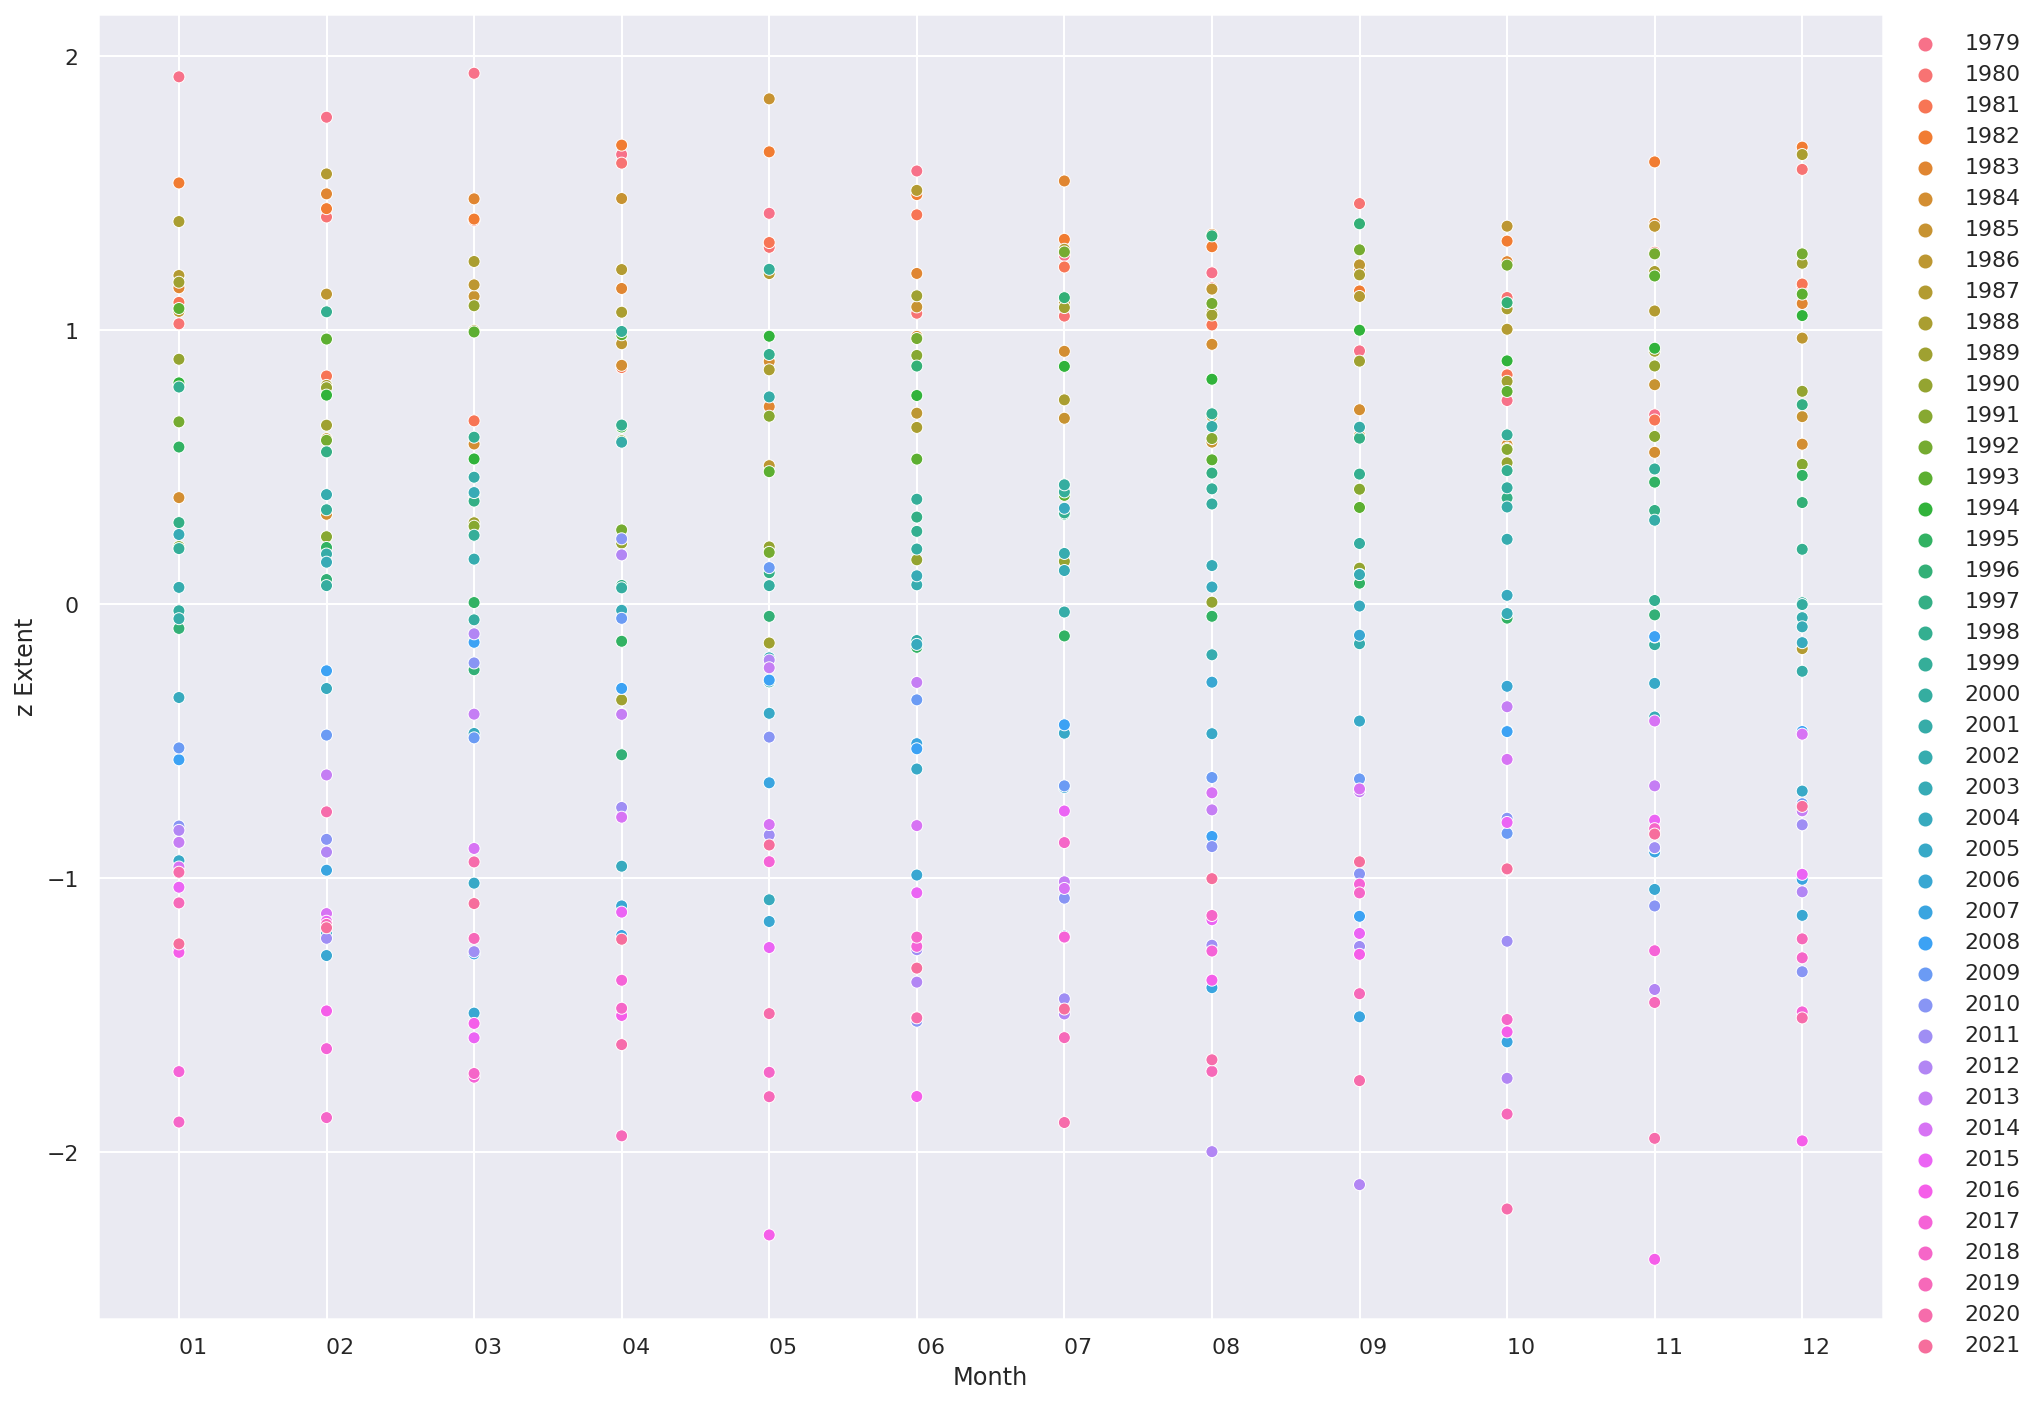

In [71]:
sns.set(rc={'figure.figsize':(16,12)})
sns.scatterplot(x="Month", y="z Extent", hue="Year", data=n_ice_z)
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig("IceExtentZscoreByMonth.png", bbox_inches='tight')

## 5) 全範囲での変化の様子を改めて見る

* 各月の個性は、すでに消した。
* その上で、全範囲での変化の様子を改めて見る
 * seabornの単回帰のプロットを利用する。

* Yearを整数にしておく
 * 以下、1年経つとどのくらい面積が変化するか、という分析をする。

In [72]:
n_ice_z.Year = n_ice_z.Year.astype(int)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


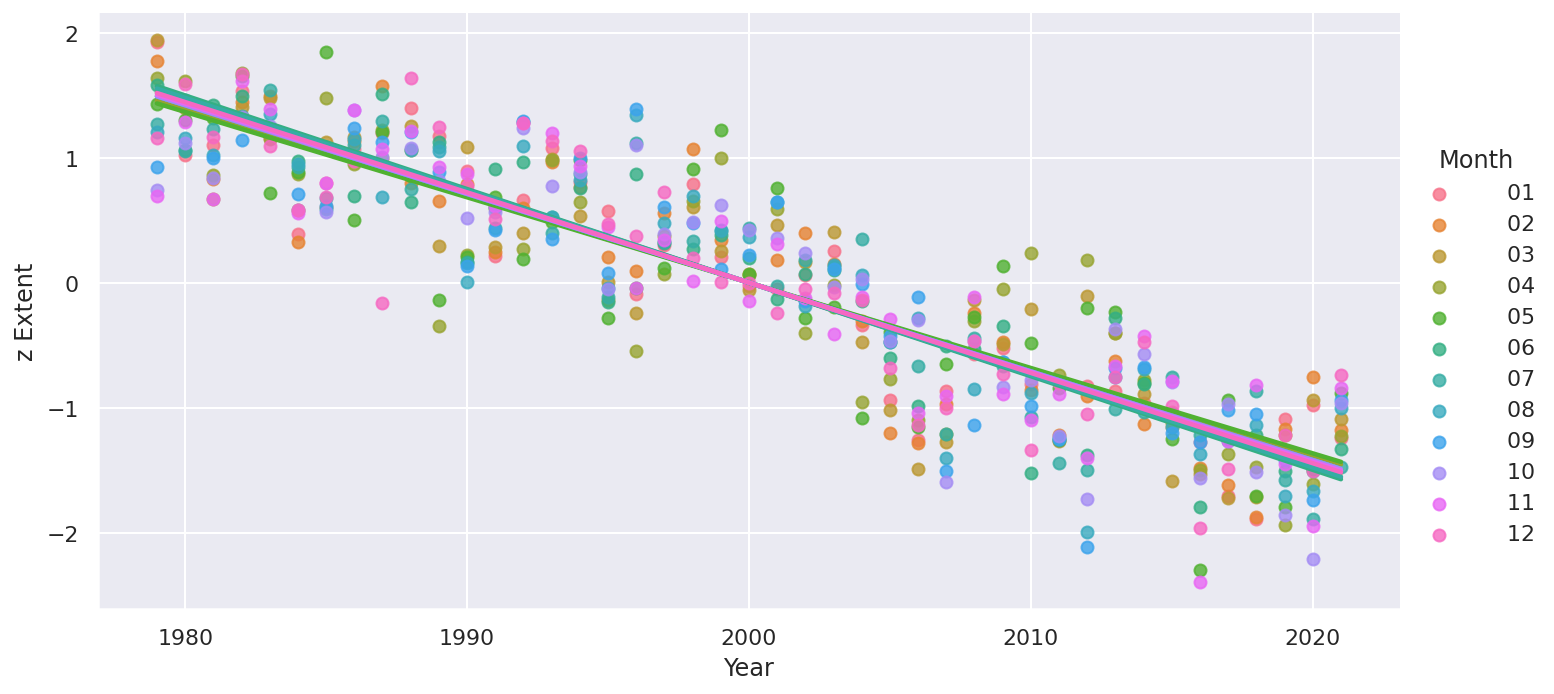

In [73]:
sns.lmplot("Year", "z Extent", n_ice_z, hue="Month", ci=None, aspect=2)
plt.savefig("IceExtentAllMonthsByYearlmplot.png", bbox_inches='tight');

* 直線でfittingしても、悪くなさそう。
* そして、面積減少の傾向が見て取れる。
 * どの月の直線も、ほとんど同じ傾き。


* ピアソンの相関係数と、無相関の検定のp値を求める。

In [79]:
for month in n_ice.Month.unique():
  x = n_ice_z[n_ice.Month == month].Year.values
  y = n_ice_z[n_ice.Month == month]["z Extent"].values
  coef, pval = sp.stats.pearsonr(x, y)
  print(f'{month}\t{coef:.3f}\t{pval:.3e}')

    01	-0.931	1.376e-19
    02	-0.910	2.922e-17
    03	-0.893	8.564e-16
    04	-0.869	4.070e-14
    05	-0.857	2.152e-13
    06	-0.940	8.569e-21
    07	-0.928	3.185e-19
    08	-0.907	5.652e-17
    09	-0.891	1.279e-15
    10	-0.891	1.184e-15
    11	-0.899	2.919e-16
    12	-0.907	5.565e-17


## 6) sklearnの線形回帰を使った分析
* 今回は、機械学習をするのではないので、予測はしない。
* 回帰直線を単に求めるだけ。
 * 予測をするときは、訓練データと検証データとテストデータに分割する必要がある。

* sklearnの`LinearRegression`で、回帰直線を求める。
 * 傾きを表示する。
 * 切片はそのまま表示せず、代わりに1979年の位置での値を表示する。

In [80]:
reg = LinearRegression()

for month in n_ice.Month.unique():
  x = n_ice_z[n_ice.Month == month].Year.values
  y = n_ice_z[n_ice.Month == month]["z Extent"].values
  reg.fit(x.reshape(-1, 1), y)
  coef = reg.coef_[0]
  intercept = reg.coef_[0] * 1979 + reg.intercept_
  print(f'{month}\t{coef:.4f}\t{intercept:.2f} ({reg.intercept_:.1f})')

    01	-0.0742	1.56 (148.3)
    02	-0.0725	1.52 (144.9)
    03	-0.0711	1.49 (142.2)
    04	-0.0692	1.45 (138.4)
    05	-0.0683	1.43 (136.6)
    06	-0.0749	1.57 (149.8)
    07	-0.0739	1.55 (147.9)
    08	-0.0722	1.52 (144.4)
    09	-0.0709	1.49 (141.9)
    10	-0.0710	1.49 (141.9)
    11	-0.0716	1.50 (143.1)
    12	-0.0722	1.52 (144.4)


* 一年ごとの変化量は、各月の標準偏差を掛け算すれば面積値に戻せる。


In [81]:
for month in n_ice.Month.unique():
  x = n_ice_z[n_ice.Month == month].Year.values
  y = n_ice_z[n_ice.Month == month]["z Extent"].values
  reg.fit(x.reshape(-1, 1), y)
  coef = reg.coef_[0] * month_stds[month]
  intercept = reg.coef_[0] * 1979 + reg.intercept_
  intercept = intercept * month_stds[month] + month_means[month]
  print(f'{month}\t{coef:.4f}\t{intercept:.2f}')

    01	-0.0454	15.19
    02	-0.0438	16.02
    03	-0.0398	16.09
    04	-0.0389	15.34
    05	-0.0354	13.86
    06	-0.0469	12.52
    07	-0.0705	10.58
    08	-0.0747	8.36
    09	-0.0813	7.70
    10	-0.0821	9.61
    11	-0.0531	11.55
    12	-0.0435	13.55


* この結果は、元の面積値データで、月毎にseabornで回帰直線を描けば、確認できる。

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


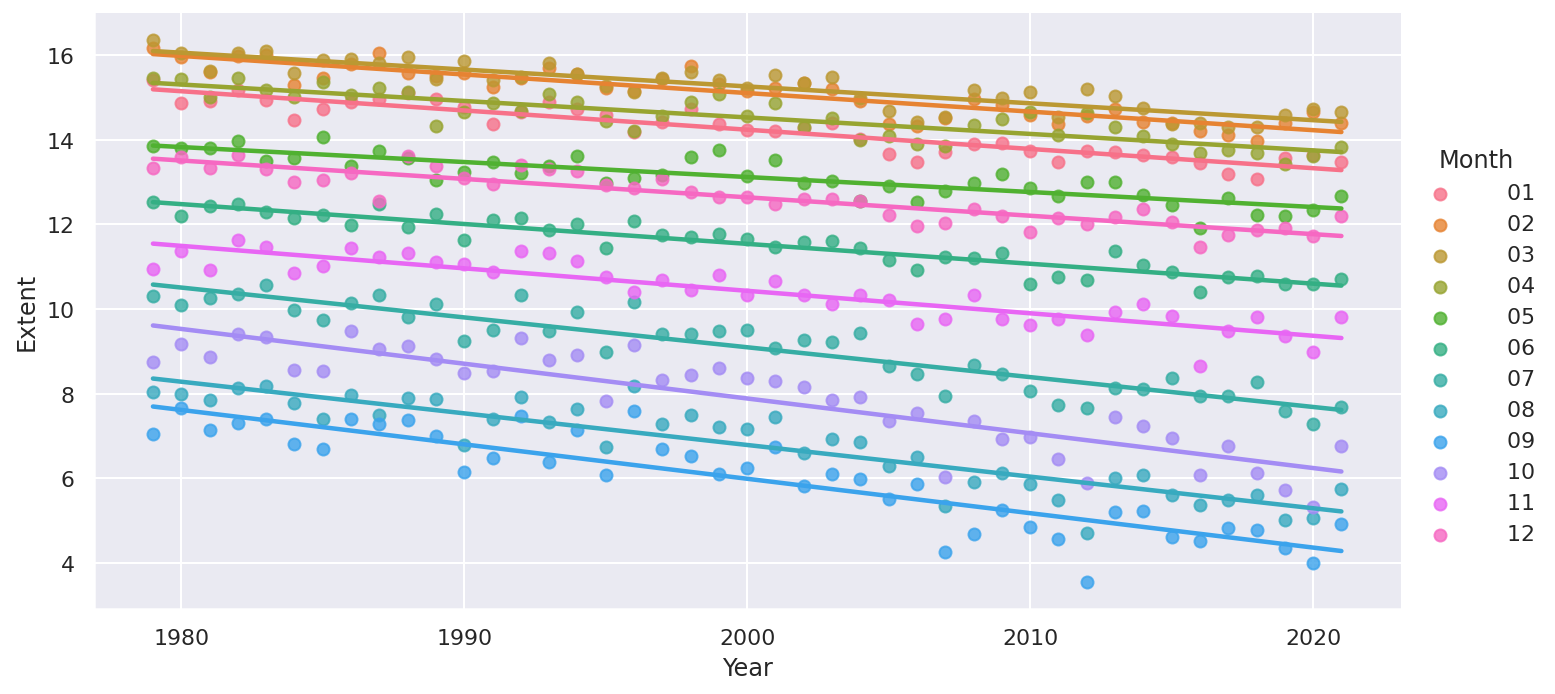

In [82]:
n_ice.Year = n_ice.Year.astype(int)
sns.lmplot("Year", "Extent", n_ice, hue="Month", ci=None, aspect=2);

* 元々の面積値を月毎に見ても、上図のようにまとまりがない。
* このバラバラ感をなくすことを、月毎に標準化するという方法で、行ったのだった。

* フィッティングの評価
 *   mean squared error (MSE)
 *   the coefficient of determination ($R^2$)



* $R^2$は$(1 - \textbf{u}/\textbf{v})$と定義される。

 * $\textbf{u}$ は残差の二乗和 $\sum (\textbf{y} - \hat{\textbf{y}})^2$。（$\hat{\textbf{y}}$が回帰による予測値。）

 * $\textbf{v}$ は、真値の平均$\bar{\textbf{y}}$ からの個々の真値$\textbf{y}$のズレの二乗の和$\sum (\textbf{y} - \bar{\textbf{y}})^2$。

 * つまり、R-squaredは、いつでもターゲットの平均値を予測値とするような単純なモデルと比較してどのくらい良いかを表している。 

 * $R^2$の最も良い値は1.0。これより小さくなるほど悪くなる。

In [84]:
reg = LinearRegression()

for month in n_ice.Month.unique():
  x = n_ice_z[n_ice.Month == month].Year.values
  y = n_ice_z[n_ice.Month == month]["z Extent"].values
  reg.fit(x.reshape(-1,1), y)

  y_hat = reg.predict(x.reshape(-1,1))
  mse = metrics.mean_squared_error(y, y_hat)
  score = metrics.r2_score(y, y_hat)
  print(f"{month}\tMSE: {mse:.3f}\tR^2: {score:.3f}")

    01	MSE: 0.130	R^2: 0.867
    02	MSE: 0.168	R^2: 0.828
    03	MSE: 0.198	R^2: 0.797
    04	MSE: 0.239	R^2: 0.756
    05	MSE: 0.259	R^2: 0.735
    06	MSE: 0.113	R^2: 0.884
    07	MSE: 0.135	R^2: 0.862
    08	MSE: 0.174	R^2: 0.822
    09	MSE: 0.202	R^2: 0.793
    10	MSE: 0.201	R^2: 0.794
    11	MSE: 0.188	R^2: 0.808
    12	MSE: 0.173	R^2: 0.822


どうやら、データは長期的なnegative trendを示している、と言ってもよさそう。


## 7) statsmodelsの線形回帰を使った分析

* こちらのほうが、統計学的な観点からの分析に向いている。
 * 検定ができるから。


* scikit-learnの線形回帰は、以下のようなモデルになっている。
$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p$$
* statsmodelsでのデフォルトの設定は、以下のように切片がないモデルになっている。
$$y = \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p$$

In [85]:
n_ice_z.head()

,Year,Month,Extent,z Extent
0,1979,01,15.414000,1.924243
1,1979,02,16.175286,1.776778
2,1979,03,16.341938,1.937229
3,1979,04,15.446800,1.640758
4,1979,05,13.856867,1.426028


In [93]:
results = dict()

for month in n_ice_z.Month.unique():
  x = n_ice_z[n_ice_z.Month == month].Year.values
  x_ = sm.add_constant(x) # 切片を追加
  y = n_ice_z[n_ice_z.Month == month].Extent.values
  model = sm.OLS(y, x_)
  results[month] = model.fit()

In [94]:
results.keys()

dict_keys(['    01', '    02', '    03', '    04', '    05', '    06', '    07', '    08', '    09', '    10', '    11', '    12'])

* statsmodelsはこのsummaryが強力。

In [95]:
results['    01']

In [96]:
results['    01'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     268.1
Date:                Sat, 21 May 2022   Prob (F-statistic):           1.38e-19
Time:                        06:36:58   Log-Likelihood:                 3.9967
No. Observations:                  43   AIC:                            -3.993
Df Residuals:                      41   BIC:                           -0.4711
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        105.0988      5.550     18.937      0.000      93.891     116.307
x1            -0.0454      0.003    -16.373      0.000      -0.051      -0.040
==============================================================================
Omnibus:                        1.888   Durbin-Watson:                   1.207
Prob(Omnibus):                  0.389   Jarque-Bera (JB):                1.798
Skew:                          -0.430   Prob(JB):                        0.407
Kurtosis:                       2.485   Cond. No.                     3.22e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [92]:
results['    12'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     189.9
Date:                Sat, 21 May 2022   Prob (F-statistic):           5.56e-17
Time:                        06:36:25   Log-Likelihood:                -23.349
No. Observations:                  43   AIC:                             50.70
Df Residuals:                      41   BIC:                             54.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        144.4470     10.483     13.780      0.000     123.277     165.617
x1            -0.0722      0.005    -13.780      0.000      -0.083      -0.062
==============================================================================
Omnibus:                        0.821   Durbin-Watson:                   1.562
Prob(Omnibus):                  0.663   Jarque-Bera (JB):                0.403
Skew:                          -0.233   Prob(JB):                        0.817
Kurtosis:                       3.085   Cond. No.                     3.22e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 課題6
南極海氷域について、同様に分析をしてみよう。

